## 1-Dimensional ROIs

## Adjusting for the number of frames

In [1]:
# init
import numpy as np
import pandas as pd
from statistics import mean


class Roi1D:
    N_HORIZONTAL: int = None
    WIDTH: int = None

    def __init__(self, x_idx):
        self.x_idx = x_idx

    def __repr__(self):
        return f'Roi1D({self.x_idx})'

    def __str__(self):
        return f'Roi1D({self.x_idx})'

    def coordinates(self):
        """Inclusive lower and upper pixel indexes"""
        left = self.x_idx * Roi1D.WIDTH
        return [left, left + Roi1D.WIDTH - 1]

    def center(self):
        return mean(self.coordinates())

In [2]:
def make_vars(n_horizontal, roi_width, n_frames):
    Roi1D.N_HORIZONTAL = n_horizontal
    Roi1D.WIDTH = roi_width
    rois = [Roi1D(x) for x in range(Roi1D.N_HORIZONTAL)]
    signals_df = pd.DataFrame({roi: np.full(shape=n_frames, fill_value=roi.center()) for roi in rois})
    spatial_indexes = pd.DataFrame({roi: [roi.center()] for roi in rois}, index=['center'])
    signals_indexes = pd.concat([spatial_indexes, signals_df])
    return rois, signals_df, spatial_indexes, signals_indexes

<Axes: >

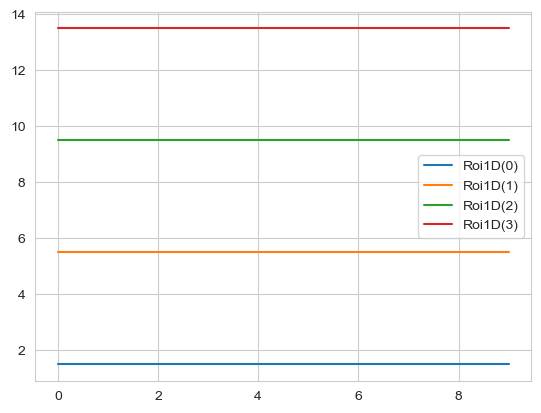

In [3]:
n_frames = 10
rois, signals_df, spatial_indexes, signals_indexes = make_vars(n_horizontal=4, roi_width=4, n_frames=n_frames)
signals_df.plot()

In [4]:
signals_indexes

,Roi1D(0),Roi1D(1),Roi1D(2),Roi1D(3)
center,1.5,5.5,9.5,13.5
0,1.5,5.5,9.5,13.5
1,1.5,5.5,9.5,13.5
2,1.5,5.5,9.5,13.5
3,1.5,5.5,9.5,13.5
4,1.5,5.5,9.5,13.5
5,1.5,5.5,9.5,13.5
6,1.5,5.5,9.5,13.5
7,1.5,5.5,9.5,13.5
8,1.5,5.5,9.5,13.5


In [18]:
from scipy.spatial.distance import euclidean

def add_distances_to_df(dists, n_frames, roi0, roi1, signals_df, spatial_indexes, signals_indexes):
        dists.loc[n_frames, 'Original Signal Distance'] = euclidean(signals_df[roi0], signals_df[roi1])
        #     # 'Normalized Signals:': euclidean(normalized_signals[roi0], normalized_signals[roi1]),
        dists.loc[n_frames, 'Spatial Distance'] = euclidean(spatial_indexes[roi0], spatial_indexes[roi1])
        dists.loc[n_frames, 'Signals and spatial indexes Distance'] = euclidean(signals_indexes[roi0],
                                                                                signals_indexes[roi1])

In [19]:
distances = pd.DataFrame()
for n_frames in [1, 2, 3, 5, 10, 50, 100, 1_000, 10_000, 100_000]:
    rois, signals_df, spatial_indexes, signals_indexes = make_vars(n_horizontal=4, roi_width=4, n_frames=n_frames)
    add_distances_to_df(distances, n_frames, rois[0], rois[1], signals_df, spatial_indexes, signals_indexes)
distances

,Original Signal Distance,Spatial Distance,Signals and spatial indexes Distance
1,4.000000,4.0,5.656854
2,5.656854,4.0,6.928203
3,6.928203,4.0,8.000000
5,8.944272,4.0,9.797959
10,12.649111,4.0,13.266499
50,28.284271,4.0,28.565714
100,40.000000,4.0,40.199502
1000,126.491106,4.0,126.554336
10000,400.000000,4.0,400.020000
100000,1264.911064,4.0,1264.917389


## Formulas
#### Euclidean Distance
$a$: roi1  
$b$: roi2  
$c$: center  
$s$: signal  
$n$: number of frames  
$E(a,b) = \sqrt{ (c^{(a)} - c^{(b)})^2 + \sum_{i=0}^{n-1} (s^{(a)}_i - s^{(b)}_i)^2}$

-> The left and right terms should be weighed equally, because the spatial distance should be weighed as heavily as the signal distance, but if $n>1$ the right part larger than the left part.  
-> To compensate for this, we multiply the left part by $n$.  
This gives us $n(c^{(a)} - c^{(b)})^2 $
$=(\sqrt n c^{(a)} - \sqrt n c^{(b)})^2$  
-> Thus, we scale the centers by $\sqrt n$ to weigh them equally and get the following formula:

$E(a,b) = \sqrt{ (\sqrt n c^{(a)} - \sqrt n c^{(b)})^2 + \sum_{i=0}^{n-1} (s^{(a)}_i - s^{(b)}_i)^2}$

In [20]:
distances = pd.DataFrame()
for n_frames in [1, 2, 3, 5, 10, 50, 100, 1_000, 10_000, 100_000]:
    rois, signals_df, spatial_indexes, _ = make_vars(n_horizontal=4, roi_width=4, n_frames=n_frames)
    # -------------------------- THIS IS THE IMPORTANT ADJUSTMENT: -----------
    spatial_indexes *= np.sqrt(n_frames)
    # ------------------------------------------------------------------------
    signals_indexes = pd.concat([spatial_indexes, signals_df])
    add_distances_to_df(distances, n_frames, rois[1], rois[3], signals_df, spatial_indexes, signals_indexes)
distances

,Original Signal Distance,Spatial Distance,Signals and spatial indexes Distance
1,8.000000,8.000000,11.313708
2,11.313708,11.313708,16.000000
3,13.856406,13.856406,19.595918
5,17.888544,17.888544,25.298221
10,25.298221,25.298221,35.777088
50,56.568542,56.568542,80.000000
100,80.000000,80.000000,113.137085
1000,252.982213,252.982213,357.770876
10000,800.000000,800.000000,1131.370850
100000,2529.822128,2529.822128,3577.708764


#### -> The spatial and signal distance is now weighed equally for all `n_frames`.